<a href="https://colab.research.google.com/github/AlexUCAS/VtoT_TC/blob/main/VtoT_TC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The program shows an analytic conversion from type K thermocouple voltage to temperature via fitting the conversion table. The table has the reference point at zero degree Celcius. 

# 1. extract table in pdf into numpy array 

In [427]:
## PyPDF2 needed
# !pip install PyPDF2

In [428]:
from PyPDF2 import PdfReader
import numpy as np

In [429]:
reader = PdfReader('/content/V_T_table.pdf')
indicators = ['\n10', '\n 200', '\n 700']  # useful data extracted after these characters 


def extract_data(page_number):
  pages = reader.pages[page_number]  # the first page of pdf
  text = pages.extract_text(0)       # vertical character only
  indicator = indicators[page_number]
  text = text[text.find(indicator) + 1:]
  text = text.replace('.\n', '.')
  text = text.replace('. ', '.')  
  text = text.replace('10.60 ', '10.60')
  text = text.replace('21.92 ', '21.924')
  text = text.replace('37.92 ', '37.92')
  text = text.replace('42.55 ', '42.55')  # fixing number extration error
  
  # 13 numbers each line (2 for temperature at ends, 11 voltage values)
  number = np.fromstring(text, dtype=float, sep=' ')
  number = number.reshape(-1, 13)
  return number

for page_number in range(3):
  if page_number == 0:
    number = extract_data(page_number)
  else:
    number = np.concatenate((number, extract_data(page_number)), axis=0)
    # extract_data(page_number)
np.set_printoptions(suppress=True)
print(number, number.shape)

[[  10.       0.397    0.437 ...    0.758    0.798   10.   ]
 [  20.       0.798    0.838 ...    1.163    1.203   20.   ]
 [  30.       1.203    1.244 ...    1.571    1.612   30.   ]
 ...
 [1170.      47.737   47.774 ...   48.069   48.105 1170.   ]
 [1180.      48.105   48.142 ...   48.436   48.473 1180.   ]
 [1190.      48.473   48.509 ...   48.802   48.838 1190.   ]] (119, 13)


# 2. fit T vs U

Text(0, 0.5, 'temperature($^\\circ$C)')

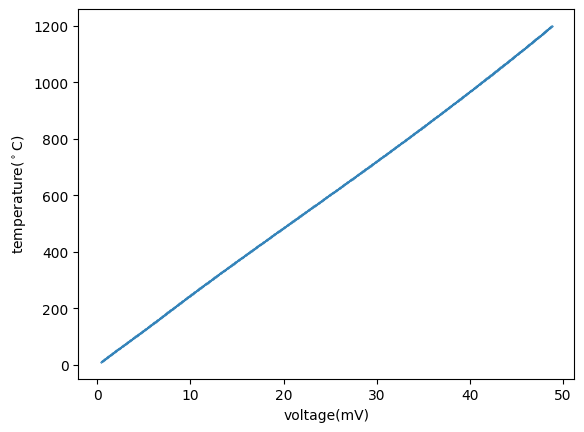

In [430]:
import matplotlib.pyplot as plt

T = np.arange(10, 1200, 1)
U = number[:, 1:-2].flatten()  # the last column of temperature is redundant

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(U, T, s=0.1)
ax.set_xlabel('voltage(mV)')
ax.set_ylabel('temperature($^\circ$C)')

In [431]:
## try lmfit
# !pip install lmfit

In [432]:
from lmfit.models import PolynomialModel
from lmfit import Minimizer

for degree in range(1, 6):
  model = PolynomialModel(degree)
  params = model.guess(T, x=U)
  result = model.fit(T, params, x=U)
  # result.plot_fit(xlabel='voltage(mV)', ylabel='temperature($^\circ$C)')
  T_predict = result.eval(x=U)
  print('the largest deviation from the actual temperature for degree=', degree, ' is ', max(np.amax(T[150:800]-T_predict[150:800]), -np.amin(T[150:800]-T_predict[150:800])), 'degree Celsius')
  plt.show()

the largest deviation from the actual temperature for degree= 1  is  6.829117142082396 degree Celsius
the largest deviation from the actual temperature for degree= 2  is  5.085310917276615 degree Celsius
the largest deviation from the actual temperature for degree= 3  is  1.8221913158091638 degree Celsius
the largest deviation from the actual temperature for degree= 4  is  1.5671605834263573 degree Celsius
the largest deviation from the actual temperature for degree= 5  is  0.7767832629741918 degree Celsius


In [433]:
model = PolynomialModel(3)
params = model.guess(T, x=U)
result = model.fit(T, params, x=U)
print(result.fit_report())

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 1190
    # variables        = 4
    chi-square         = 631.984140
    reduced chi-square = 0.53287027
    Akaike info crit   = -745.084703
    Bayesian info crit = -724.757868
    R-squared          = 0.99999550
[[Variables]]
    c0: -2.99350260 +/- 0.08987690 (3.00%) (init = -2.993503)
    c1:  25.8269743 +/- 0.01568290 (0.06%) (init = 25.82697)
    c2: -0.10671254 +/- 7.3449e-04 (0.69%) (init = -0.1067125)
    c3:  0.00168575 +/- 9.7761e-06 (0.58%) (init = 0.001685749)
[[Correlations]] (unreported correlations are < 0.100)
    C(c2, c3) = -0.986
    C(c1, c2) = -0.970
    C(c1, c3) = 0.920
    C(c0, c1) = -0.879
    C(c0, c2) = 0.766
    C(c0, c3) = -0.685


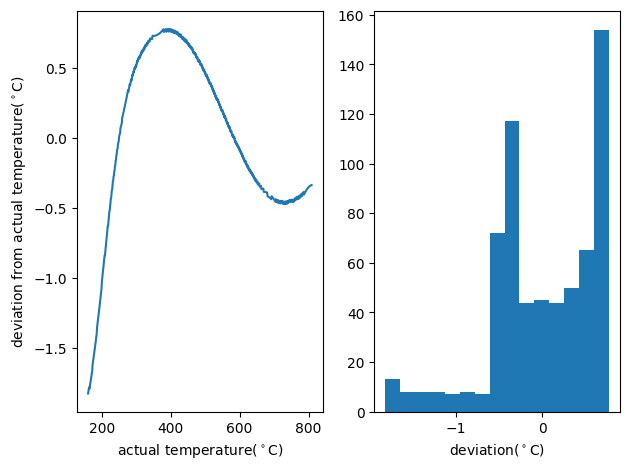

In [434]:
T_predict = result.eval(x=U)
fig = plt.figure()
ax2 = fig.add_subplot(121)
ax2.plot(T[150:800], T[150:800]-T_predict[150:800])
ax2.set_xlabel('actual temperature($^\circ$C)')
ax2.set_ylabel('deviation from actual temperature($^\circ$C)')
ax3 = fig.add_subplot(122)
ax3.hist(T[150:800]-T_predict[150:800], bins=15)
ax3.set_xlabel('deviation($^\circ$C)')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Model(polynomial)'}, xlabel='voltage(mV)', ylabel='temperature($^\\circ$C)'>

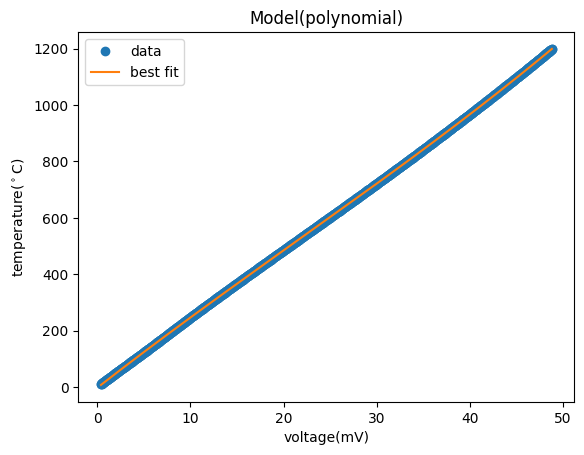

In [435]:
result.plot_fit(xlabel='voltage(mV)', ylabel='temperature($^\circ$C)')

# Conclusion

Within the temperature of interest: around 200 degree Celsius to 800 degree Celsius, the deviation of polynomial fit up to the cubic term is acceptable (less than 2 degree Celsius). We can use
\begin{equation*}
  T = -2.99350260 + 25.8269743 * U - 0.10671254 * U^2 + 0.00168575 * U^3
\end{equation*}
to convert thermocouple voltage to temperature, where $U$ is thermocouple voltage with reference point at 0 degree Celsius. Pratically, the thermocouple voltage for conversion is the actual reading at a given temperature minus the one measured at 0$^\circ C$.